<a href="https://colab.research.google.com/github/brenoslivio/MDNE_2024/blob/main/Project_2/Projeto2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## SCC5920 - Mineração de Dados Não Estruturados (2024)

**Projeto 2: Mineração de Imagens - Classificação de Abelhas e Vespas**

Prof. Ricardo Marcacini

**Aluno:** Breno Livio Silva de Almeida

**NUSP:** 10276675

---

In [1]:
!git clone https://github.com/brenoslivio/MDNE_2024.git

fatal: destination path 'MDNE_2024' already exists and is not an empty directory.


In [16]:
!pip install mahotas
!pip install optuna
import mahotas as mt
import polars as pl
import cv2
import cv2 as cv
import numpy as np
import os
import glob
import optuna
from google.colab.patches import cv2_imshow
from skimage import io
from PIL import Image
import matplotlib.pylab as plt
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score, f1_score, matthews_corrcoef, recall_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict

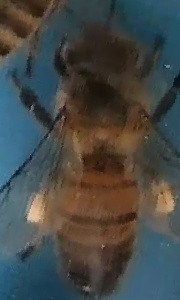

In [3]:
dataset_path = "MDNE_2024/Project_2/dataset"

df_bees = pl.read_csv(os.path.join(dataset_path, "labels.csv")).filter((pl.col("label") == "bee") | (pl.col("label") == "wasp") & (pl.col("photo_quality") == 1) & (pl.col("path") != "wasp1\\image.png"))

df_train = df_bees.filter(pl.col("is_final_validation") == 0)
df_val = df_bees.filter((pl.col("is_validation") == 0) & (pl.col("is_final_validation") == 1))

image = io.imread(os.path.join(dataset_path, df_train["path"].sample(1).item().replace("\\", "/")))
cv2_imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [4]:
df_train["label"].value_counts()

label,count
str,u32
"""bee""",2679
"""wasp""",1798


In [5]:
df_val["label"].value_counts()

label,count
str,u32
"""bee""",504
"""wasp""",328


### Características de Texturas

In [6]:
def extract_haralick(img_path):
  image = io.imread(os.path.join(dataset_path, img_path.replace("\\", "/")))
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  textures = mt.features.haralick(image)
  features = {}

  ht_mean = textures.mean(axis=0)

  for i, feature in enumerate(mt.features.texture.haralick_labels[:-1]):
    features[feature] = ht_mean[i]

  return features

df_train_haralick = df_train.with_columns(pl.col("path").map_elements(lambda x: extract_haralick(x)).alias("features")).unnest("features")
df_train_haralick

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.


id,path,is_bee,is_wasp,is_otherinsect,is_other,photo_quality,is_validation,is_final_validation,label,Angular Second Moment,Contrast,Correlation,Sum of Squares: Variance,Inverse Difference Moment,Sum Average,Sum Variance,Sum Entropy,Entropy,Difference Variance,Difference Entropy,Information Measure of Correlation 1,Information Measure of Correlation 2
i64,str,i64,i64,i64,i64,i64,i64,i64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1,"""bee1\10007154554_026417cfd0_n.…",1,0,0,0,1,0,0,"""bee""",0.008061,3948.304822,0.653884,5909.264871,0.171371,208.881818,19688.754663,8.40521,13.224486,0.000146,6.025976,-0.22159,0.94823
3,"""bee1\10092043833_7306dfd1f0_n.…",1,0,0,0,1,1,0,"""bee""",0.00014,2245.1284,0.704201,3862.044483,0.111504,212.728164,13203.049532,8.767122,14.241819,0.000143,5.965364,-0.180153,0.910828
5,"""bee1\10128235063_dca17db76c_n.…",1,0,0,0,1,0,0,"""bee""",0.000122,3777.430951,0.560447,4354.136061,0.100561,246.535115,13639.113294,8.76776,14.289513,0.00014,6.085442,-0.185808,0.896628
6,"""bee1\10130729734_f68738333e_w.…",1,0,0,0,1,0,0,"""bee""",0.000803,1168.905381,0.855969,4128.8372,0.262922,292.066784,15346.443418,8.589249,12.65934,0.00032,4.922086,-0.32292,0.991448
7,"""bee1\10166485783_9cd6706c72_n.…",1,0,0,0,1,0,0,"""bee""",0.001138,910.963828,0.492477,932.590832,0.206791,248.978818,2819.399501,7.651895,11.669624,0.000458,4.760354,-0.30617,0.967111
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
5303,"""wasp1\9931084786_6c1de01c56_m.…",0,1,0,0,1,0,0,"""wasp""",0.000254,1028.118485,0.78687,2448.327669,0.11835,230.883562,8765.192192,8.379834,13.477788,0.000169,5.504822,-0.213269,0.950939
5304,"""wasp1\9974913676_226cac235d_n.…",0,1,0,0,1,0,0,"""wasp""",0.000245,3457.096761,0.475368,3350.864457,0.112277,212.752544,9946.361066,8.502058,13.880918,0.000136,6.073983,-0.194133,0.938016
5305,"""wasp1\9982829004_31a27d7db7_n.…",0,1,0,0,1,0,0,"""wasp""",0.000125,3670.520116,0.530473,3961.4218,0.088983,253.841527,12175.167083,8.635778,13.957525,0.000103,6.103158,-0.200999,0.960762


In [7]:
def objective(trial):
    C = trial.suggest_float("svm_C", 1e-6, 1e1, log=True)
    gamma = trial.suggest_categorical("svm_gamma", ["scale", "auto"])
    kernel = trial.suggest_categorical("svm_kernel", ["linear", "poly", "rbf", "sigmoid"])

    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("svm", SVC(C=C, kernel=kernel, gamma=gamma, random_state=0))
    ])

    scores = cross_val_score(pipeline, X_train, y_train, cv=10, scoring=make_scorer(f1_score, pos_label="bee"))

    return np.mean(scores)

X_train, y_train = df_train_haralick.select(pl.nth(range(10, len(df_train_haralick.columns)))).to_numpy(), df_train_haralick["label"].to_numpy()

sampler = optuna.samplers.TPESampler(seed=0)
study1 = optuna.create_study(direction="maximize", sampler=sampler)
study1.optimize(objective, n_trials=100)

print("Best hyperparameters:", study1.best_params)
print(f"Best F1-score: {study1.best_value:.4f}")

[I 2024-10-05 23:44:54,399] A new study created in memory with name: no-name-e317e86b-4b65-4a65-bc38-e63bdf513eb8
[I 2024-10-05 23:45:03,842] Trial 0 finished with value: 0.7487423322651715 and parameters: {'svm_C': 0.006945356257424776, 'svm_gamma': 'scale', 'svm_kernel': 'rbf'}. Best is trial 0 with value: 0.7487423322651715.
[I 2024-10-05 23:45:12,687] Trial 1 finished with value: 0.5240138971004098 and parameters: {'svm_C': 1.7474751375465036, 'svm_gamma': 'scale', 'svm_kernel': 'sigmoid'}. Best is trial 0 with value: 0.7487423322651715.
[I 2024-10-05 23:45:24,441] Trial 2 finished with value: 0.7487423322651715 and parameters: {'svm_C': 3.1423344550041226e-06, 'svm_gamma': 'scale', 'svm_kernel': 'sigmoid'}. Best is trial 0 with value: 0.7487423322651715.
[I 2024-10-05 23:45:33,766] Trial 3 finished with value: 0.5261034094201459 and parameters: {'svm_C': 0.3927443531634939, 'svm_gamma': 'auto', 'svm_kernel': 'sigmoid'}. Best is trial 0 with value: 0.7487423322651715.
[I 2024-10-05

Best hyperparameters: {'svm_C': 1.7210083768862503, 'svm_gamma': 'scale', 'svm_kernel': 'rbf'}
Best F1-score: 0.7910


In [8]:
df_val_haralick = df_val.with_columns(pl.col("path").map_elements(lambda x: extract_haralick(x)).alias("features")).unnest("features")
df_val_haralick

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.


id,path,is_bee,is_wasp,is_otherinsect,is_other,photo_quality,is_validation,is_final_validation,label,Angular Second Moment,Contrast,Correlation,Sum of Squares: Variance,Inverse Difference Moment,Sum Average,Sum Variance,Sum Entropy,Entropy,Difference Variance,Difference Entropy,Information Measure of Correlation 1,Information Measure of Correlation 2
i64,str,i64,i64,i64,i64,i64,i64,i64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2,"""bee1\10024864894_6dc54d4b34_n.…",1,0,0,0,1,0,1,"""bee""",0.00085,5899.638137,0.479574,5939.060905,0.113345,224.754955,17856.605484,8.535219,13.433414,0.000141,6.355873,-0.217756,0.951756
4,"""bee1\1011948979_fc3637e779_w.j…",1,0,0,0,1,0,1,"""bee""",0.000256,903.109332,0.917788,5495.223697,0.147249,192.472889,21077.785456,8.597804,13.410387,0.000169,5.414926,-0.23928,0.980368
23,"""bee1\1044467943_594f56bd36_n.j…",1,0,0,0,1,0,1,"""bee""",0.00214,5288.186123,0.560274,6208.563251,0.109996,172.56559,19546.066881,8.394622,12.961501,0.00011,6.350426,-0.195994,0.939822
37,"""bee1\1154438668_037d503906_m.j…",1,0,0,0,1,0,1,"""bee""",0.000077,777.101868,0.853983,2663.23709,0.061898,249.243076,9875.846491,8.613202,14.117887,0.000083,5.739722,-0.160995,0.951708
40,"""bee1\11609248916_80ea630895_n.…",1,0,0,0,1,0,1,"""bee""",0.000191,2049.046481,0.647137,2880.766025,0.100261,229.932181,9474.017619,8.512633,13.938231,0.000143,5.90609,-0.179303,0.897315
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
5280,"""wasp1\9609935234_7bd4909970_m.…",0,1,0,0,1,0,1,"""wasp""",0.000476,870.232582,0.914593,5188.661688,0.16018,271.823308,19884.414168,8.337198,12.473341,0.000284,4.945424,-0.331919,0.992951
5286,"""wasp1\9651510344_fe786ed064_n.…",0,1,0,0,1,0,1,"""wasp""",0.000756,756.17444,0.933571,5679.594721,0.134631,254.555266,21962.204445,8.861404,13.786164,0.000131,5.453691,-0.245763,0.98736
5301,"""wasp1\9846164973_4245decd39_w.…",0,1,0,0,1,0,1,"""wasp""",0.000507,1384.240648,0.552956,1561.219168,0.156423,136.851552,4860.636026,7.93391,12.826891,0.000196,5.556098,-0.168827,0.888721


In [9]:
best_params = study1.best_params

best_model = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(C=best_params["svm_C"], kernel=best_params["svm_kernel"], gamma=best_params["svm_gamma"]))
])

X_test, y_test = df_val_haralick.select(pl.nth(range(10, len(df_val_haralick.columns)))).to_numpy(), df_val_haralick["label"].to_numpy()

best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         bee       0.76      0.87      0.81       504
        wasp       0.74      0.58      0.65       328

    accuracy                           0.75       832
   macro avg       0.75      0.72      0.73       832
weighted avg       0.75      0.75      0.75       832



### Características de Cores

In [12]:
def extract_colors(img_path):
  color = ('b','g','r')
  dataset_hist_r = []
  dataset_hist_g = []
  dataset_hist_b = []

  image = io.imread(os.path.join(dataset_path, img_path.replace("\\", "/")))
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  hists = {}

  for i, col in enumerate(color):
    histr = cv.calcHist([image],[i],None,[4],[0,256])
    if col == 'r': dataset_hist_r.append(histr)
    if col == 'g': dataset_hist_g.append(histr)
    if col == 'b': dataset_hist_b.append(histr)

  X_r = np.array(dataset_hist_r)
  X_g = np.array(dataset_hist_g)
  X_b = np.array(dataset_hist_b)

  X_colors = np.concatenate((X_r,X_g,X_b),axis=1).reshape(1, 12)

  colors_features = {}

  for i, feature in enumerate(X_colors[0]):
    colors_features[f"feature_{i}"] = feature

  return colors_features

df_train_colors = df_train.with_columns(pl.col("path").map_elements(lambda x: extract_colors(x)).alias("features")).unnest("features")
df_train_colors

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.


id,path,is_bee,is_wasp,is_otherinsect,is_other,photo_quality,is_validation,is_final_validation,label,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11
i64,str,i64,i64,i64,i64,i64,i64,i64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1,"""bee1\10007154554_026417cfd0_n.…",1,0,0,0,1,0,0,"""bee""",11066.0,7226.0,11167.0,38701.0,25249.0,22957.0,19703.0,251.0,33418.0,18236.0,16437.0,69.0
3,"""bee1\10092043833_7306dfd1f0_n.…",1,0,0,0,1,1,0,"""bee""",12590.0,28181.0,26282.0,18067.0,13483.0,31867.0,32113.0,7657.0,53969.0,23812.0,6113.0,1226.0
5,"""bee1\10128235063_dca17db76c_n.…",1,0,0,0,1,0,0,"""bee""",1662.0,4267.0,32744.0,43247.0,17347.0,31117.0,21553.0,11903.0,33180.0,43332.0,5285.0,123.0
6,"""bee1\10130729734_f68738333e_w.…",1,0,0,0,1,0,0,"""bee""",9805.0,18147.0,46777.0,30871.0,9690.0,14976.0,49500.0,31434.0,28578.0,17982.0,32554.0,26486.0
7,"""bee1\10166485783_9cd6706c72_n.…",1,0,0,0,1,0,0,"""bee""",392.0,9791.0,56478.0,1286.0,1534.0,25888.0,40207.0,318.0,4134.0,61330.0,1903.0,580.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
5303,"""wasp1\9931084786_6c1de01c56_m.…",0,1,0,0,1,0,0,"""wasp""",3862.0,31392.0,16058.0,6288.0,3509.0,34429.0,14992.0,4670.0,13672.0,28502.0,10253.0,5173.0
5304,"""wasp1\9974913676_226cac235d_n.…",0,1,0,0,1,0,0,"""wasp""",7915.0,30079.0,20230.0,9936.0,6343.0,27740.0,26763.0,7314.0,42176.0,25290.0,688.0,6.0
5305,"""wasp1\9982829004_31a27d7db7_n.…",0,1,0,0,1,0,0,"""wasp""",5174.0,21130.0,27587.0,28029.0,4898.0,21431.0,31232.0,24359.0,46848.0,34754.0,291.0,27.0


In [13]:
def objective(trial):
    C = trial.suggest_float("svm_C", 1e-6, 1e1, log=True)
    gamma = trial.suggest_categorical("svm_gamma", ["scale", "auto"])
    kernel = trial.suggest_categorical("svm_kernel", ["linear", "poly", "rbf", "sigmoid"])

    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("svm", SVC(C=C, kernel=kernel, gamma=gamma, random_state=0))
    ])

    scores = cross_val_score(pipeline, X_train, y_train, cv=10, scoring=make_scorer(f1_score, pos_label="bee"))

    return np.mean(scores)

X_train, y_train = df_train_colors.select(pl.nth(range(10, len(df_train_colors.columns)))).to_numpy(), df_train_colors["label"].to_numpy()

sampler = optuna.samplers.TPESampler(seed=0)
study2 = optuna.create_study(direction="maximize", sampler=sampler)
study2.optimize(objective, n_trials=100)

print("Best hyperparameters:", study2.best_params)
print(f"Best F1-score: {study2.best_value:.4f}")

[I 2024-10-06 00:54:36,555] A new study created in memory with name: no-name-b5b95f03-56b2-43f2-8866-4c2c95b73298
[I 2024-10-06 00:54:45,172] Trial 0 finished with value: 0.7487423322651715 and parameters: {'svm_C': 0.006945356257424776, 'svm_gamma': 'scale', 'svm_kernel': 'rbf'}. Best is trial 0 with value: 0.7487423322651715.
[I 2024-10-06 00:54:54,007] Trial 1 finished with value: 0.5591428177281692 and parameters: {'svm_C': 1.7474751375465036, 'svm_gamma': 'scale', 'svm_kernel': 'sigmoid'}. Best is trial 0 with value: 0.7487423322651715.
[I 2024-10-06 00:55:05,732] Trial 2 finished with value: 0.7487423322651715 and parameters: {'svm_C': 3.1423344550041226e-06, 'svm_gamma': 'scale', 'svm_kernel': 'sigmoid'}. Best is trial 0 with value: 0.7487423322651715.
[I 2024-10-06 00:55:13,974] Trial 3 finished with value: 0.5945959408543768 and parameters: {'svm_C': 0.3927443531634939, 'svm_gamma': 'auto', 'svm_kernel': 'sigmoid'}. Best is trial 0 with value: 0.7487423322651715.
[I 2024-10-06

Best hyperparameters: {'svm_C': 6.951102804103286, 'svm_gamma': 'scale', 'svm_kernel': 'rbf'}
Best F1-score: 0.7838


In [14]:
df_val_colors = df_val.with_columns(pl.col("path").map_elements(lambda x: extract_colors(x)).alias("features")).unnest("features")
df_val_colors

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.


id,path,is_bee,is_wasp,is_otherinsect,is_other,photo_quality,is_validation,is_final_validation,label,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11
i64,str,i64,i64,i64,i64,i64,i64,i64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2,"""bee1\10024864894_6dc54d4b34_n.…",1,0,0,0,1,0,1,"""bee""",6427.0,22205.0,5874.0,33441.0,8185.0,32805.0,16503.0,10454.0,52353.0,13619.0,1861.0,114.0
4,"""bee1\1011948979_fc3637e779_w.j…",1,0,0,0,1,0,1,"""bee""",41439.0,22879.0,22545.0,19937.0,56253.0,13177.0,22140.0,15230.0,47099.0,18011.0,29521.0,12169.0
23,"""bee1\1044467943_594f56bd36_n.j…",1,0,0,0,1,0,1,"""bee""",12684.0,23242.0,18312.0,26722.0,27978.0,24880.0,24085.0,4017.0,78503.0,2047.0,343.0,67.0
37,"""bee1\1154438668_037d503906_m.j…",1,0,0,0,1,0,1,"""bee""",2862.0,18968.0,19862.0,4388.0,4924.0,19854.0,14902.0,6400.0,10282.0,16827.0,12895.0,6076.0
40,"""bee1\11609248916_80ea630895_n.…",1,0,0,0,1,0,1,"""bee""",12050.0,38937.0,23508.0,2305.0,7573.0,16367.0,44640.0,8220.0,25986.0,37594.0,11469.0,1751.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
5280,"""wasp1\9609935234_7bd4909970_m.…",0,1,0,0,1,0,1,"""wasp""",2639.0,28585.0,5195.0,21181.0,3024.0,27669.0,6083.0,20824.0,29726.0,3440.0,3307.0,21127.0
5286,"""wasp1\9651510344_fe786ed064_n.…",0,1,0,0,1,0,1,"""wasp""",15173.0,15726.0,19218.0,16763.0,17452.0,14232.0,17893.0,17303.0,18676.0,21589.0,13908.0,12707.0
5301,"""wasp1\9846164973_4245decd39_w.…",0,1,0,0,1,0,1,"""wasp""",23219.0,75593.0,5352.0,2636.0,34444.0,67583.0,4018.0,755.0,99410.0,6300.0,907.0,183.0


In [15]:
best_params = study2.best_params

best_model = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(C=best_params["svm_C"], kernel=best_params["svm_kernel"], gamma=best_params["svm_gamma"]))
])

X_test, y_test = df_val_colors.select(pl.nth(range(10, len(df_val_colors.columns)))).to_numpy(), df_val_colors["label"].to_numpy()

best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         bee       0.80      0.81      0.81       504
        wasp       0.71      0.69      0.70       328

    accuracy                           0.76       832
   macro avg       0.75      0.75      0.75       832
weighted avg       0.76      0.76      0.76       832



In [17]:
model = models.resnet18(pretrained=True)

layer = model._modules.get('avgpool')
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 126MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [24]:
scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

def extract_embeddings(img_path):
    img = Image.open(os.path.join(dataset_path, img_path.replace("\\", "/")))
    img = Variable(normalize(to_tensor(scaler(img))).unsqueeze(0))

    embedding = torch.zeros(512)

    def capture_embedding(m, i, o):
        embedding.copy_(o.data.reshape(o.data.size(1)))

    h = layer.register_forward_hook(capture_embedding)
    model(img)

    h.remove()

    embeddings_feat = {}

    for i, feature in enumerate(np.array(embedding)):
      embeddings_feat[f"embedding_{i}"] = feature

    return embeddings_feat

df_train_embed = df_train.with_columns(pl.col("path").map_elements(lambda x: extract_embeddings(x)).alias("features")).unnest("features")
df_train_embed

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.


id,path,is_bee,is_wasp,is_otherinsect,is_other,photo_quality,is_validation,is_final_validation,label,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,embedding_10,embedding_11,embedding_12,embedding_13,embedding_14,embedding_15,embedding_16,embedding_17,embedding_18,embedding_19,embedding_20,embedding_21,embedding_22,embedding_23,embedding_24,embedding_25,embedding_26,…,embedding_475,embedding_476,embedding_477,embedding_478,embedding_479,embedding_480,embedding_481,embedding_482,embedding_483,embedding_484,embedding_485,embedding_486,embedding_487,embedding_488,embedding_489,embedding_490,embedding_491,embedding_492,embedding_493,embedding_494,embedding_495,embedding_496,embedding_497,embedding_498,embedding_499,embedding_500,embedding_501,embedding_502,embedding_503,embedding_504,embedding_505,embedding_506,embedding_507,embedding_508,embedding_509,embedding_510,embedding_511
i64,str,i64,i64,i64,i64,i64,i64,i64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1,"""bee1\10007154554_026417cfd0_n.…",1,0,0,0,1,0,0,"""bee""",0.524756,0.137934,0.504504,2.463422,2.32809,0.700341,3.957559,1.158749,0.201952,0.91858,0.997762,0.170293,2.13391,1.423673,0.0,2.326156,0.367872,5.232022,3.530282,4.42499,0.270149,2.116823,0.405747,0.687779,1.963689,3.089981,2.47718,…,0.762231,0.099127,1.039393,0.124489,1.325196,0.509972,1.338629,0.036382,1.885274,0.462915,3.066356,0.15237,0.306421,1.898815,0.658978,1.521986,0.268302,0.108736,0.60749,0.951135,0.551487,1.825916,0.50952,0.744821,1.365584,0.14912,0.018674,1.048728,0.528552,0.454628,0.259594,5.733372,1.212839,0.000963,1.079044,0.15149,0.488572
3,"""bee1\10092043833_7306dfd1f0_n.…",1,0,0,0,1,1,0,"""bee""",0.163239,0.3565,1.220858,1.958052,1.139267,0.584579,2.109976,1.310277,0.612005,0.877366,0.485608,0.101202,1.527156,0.61388,0.913922,0.543131,2.240492,5.738441,2.707291,1.910688,1.901317,1.169019,0.089218,1.253331,1.008647,1.516608,1.855473,…,1.149607,0.622582,0.661147,0.22742,0.288197,0.146031,1.689142,0.093026,1.38278,0.356375,0.745603,1.871414,0.265956,3.062069,0.787671,5.807712,1.029242,0.086466,1.222842,0.9167,0.908046,1.467534,0.811366,0.413152,0.185794,0.977814,0.02374,0.87409,0.738553,0.093949,0.156035,4.045158,0.531819,0.59499,0.312187,0.277257,0.060973
5,"""bee1\10128235063_dca17db76c_n.…",1,0,0,0,1,0,0,"""bee""",0.640751,0.549574,0.305968,1.966504,2.055374,2.870138,2.589532,0.558018,0.49601,0.246089,0.653362,0.378269,1.02698,0.712124,0.019544,0.330511,0.339665,4.90518,1.385484,1.651021,1.27814,1.566634,0.833996,0.218337,1.205728,1.020644,0.310432,…,1.129666,0.707398,1.554407,1.404819,0.368669,0.276122,1.507758,0.0,1.129877,0.256574,2.076206,0.699231,0.598576,3.088332,0.141056,2.830253,0.037044,0.307626,0.006048,0.246721,0.013588,1.386741,0.550189,0.005462,1.201961,1.991937,0.038811,0.473947,0.854094,0.057953,0.341087,5.026529,0.369429,0.0,1.005452,0.173616,0.75655
6,"""bee1\10130729734_f68738333e_w.…",1,0,0,0,1,0,0,"""bee""",0.572083,1.532629,1.259645,1.567947,1.220703,1.175466,0.666279,0.699705,0.129576,0.291338,0.408902,0.077068,1.129687,0.438807,0.371769,1.103351,0.163904,2.022608,1.948716,1.530395,1.296553,1.442875,0.471364,0.816392,2.254479,0.449101,1.585374,…,0.59684,1.114054,1.11842,0.171366,0.440113,0.512632,1.61968,0.144405,1.725158,0.040818,0.765219,1.199204,0.415058,3.314738,0.065735,0.571602,0.0,0.1978,4.636971,1.015781,2.424429,0.739689,0.399583,3.540628,0.299756,1.386306,1.235603,0.848132,0.507982,1.989757,0.73787,1.503023,1.313556,1.507191,0.593585,0.705598,0.266309
7,"""bee1\10166485783_9cd6706c72_n.…",1,0,0,0,1,0,0,"""bee""",0.148512,0.065854,0.274415,2.156327,0.559714,0.526638,2.241199,2.332423,0.174585,0.768669,0.489906,0.509619,0.03389,0.341512,0.772464,1.167564,0.241593,5.780016,0.857322

In [27]:
def objective(trial):
    C = trial.suggest_float("svm_C", 1e-6, 1e1, log=True)
    gamma = trial.suggest_categorical("svm_gamma", ["scale", "auto"])
    kernel = trial.suggest_categorical("svm_kernel", ["linear", "poly", "rbf", "sigmoid"])

    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("svm", SVC(C=C, kernel=kernel, gamma=gamma, random_state=0))
    ])

    scores = cross_val_score(pipeline, X_train, y_train, cv=10, scoring=make_scorer(f1_score, pos_label="bee"))

    return np.mean(scores)

X_train, y_train = df_train_embed.drop_nulls().select(pl.nth(range(10, len(df_train_embed.columns)))).to_numpy(), df_train_embed.drop_nulls()["label"].to_numpy()

sampler = optuna.samplers.TPESampler(seed=0)
study3 = optuna.create_study(direction="maximize", sampler=sampler)
study3.optimize(objective, n_trials=100)

print("Best hyperparameters:", study3.best_params)
print(f"Best F1-score: {study3.best_value:.4f}")

[I 2024-10-06 02:18:56,747] A new study created in memory with name: no-name-d0611f6e-dae8-4704-bd75-76995089ab12
[I 2024-10-06 02:19:57,371] Trial 0 finished with value: 0.7486719130360273 and parameters: {'svm_C': 0.006945356257424776, 'svm_gamma': 'scale', 'svm_kernel': 'rbf'}. Best is trial 0 with value: 0.7486719130360273.
[I 2024-10-06 02:20:11,267] Trial 1 finished with value: 0.9290237013899546 and parameters: {'svm_C': 1.7474751375465036, 'svm_gamma': 'scale', 'svm_kernel': 'sigmoid'}. Best is trial 1 with value: 0.9290237013899546.
[I 2024-10-06 02:21:09,316] Trial 2 finished with value: 0.7486719130360273 and parameters: {'svm_C': 3.1423344550041226e-06, 'svm_gamma': 'scale', 'svm_kernel': 'sigmoid'}. Best is trial 1 with value: 0.9290237013899546.
[I 2024-10-06 02:21:28,006] Trial 3 finished with value: 0.9438795133352176 and parameters: {'svm_C': 0.3927443531634939, 'svm_gamma': 'auto', 'svm_kernel': 'sigmoid'}. Best is trial 3 with value: 0.9438795133352176.
[I 2024-10-06

Best hyperparameters: {'svm_C': 1.0999454154817512, 'svm_gamma': 'auto', 'svm_kernel': 'rbf'}
Best F1-score: 0.9554


In [29]:
df_val_embed = df_val.with_columns(pl.col("path").map_elements(lambda x: extract_embeddings(x)).alias("features")).unnest("features")
df_val_embed

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.


id,path,is_bee,is_wasp,is_otherinsect,is_other,photo_quality,is_validation,is_final_validation,label,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,embedding_10,embedding_11,embedding_12,embedding_13,embedding_14,embedding_15,embedding_16,embedding_17,embedding_18,embedding_19,embedding_20,embedding_21,embedding_22,embedding_23,embedding_24,embedding_25,embedding_26,…,embedding_475,embedding_476,embedding_477,embedding_478,embedding_479,embedding_480,embedding_481,embedding_482,embedding_483,embedding_484,embedding_485,embedding_486,embedding_487,embedding_488,embedding_489,embedding_490,embedding_491,embedding_492,embedding_493,embedding_494,embedding_495,embedding_496,embedding_497,embedding_498,embedding_499,embedding_500,embedding_501,embedding_502,embedding_503,embedding_504,embedding_505,embedding_506,embedding_507,embedding_508,embedding_509,embedding_510,embedding_511
i64,str,i64,i64,i64,i64,i64,i64,i64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2,"""bee1\10024864894_6dc54d4b34_n.…",1,0,0,0,1,0,1,"""bee""",0.073299,0.694999,1.460509,2.136838,3.199918,0.057925,1.363664,1.177955,0.681428,0.151512,0.369274,0.151505,1.034565,1.953622,0.127675,0.53738,0.527236,5.859966,2.0459,3.227757,1.041126,1.313829,0.694117,1.402865,0.226312,0.776973,0.745277,…,1.400436,0.13506,1.991893,0.387704,0.526591,0.694013,2.515328,0.305568,0.438602,0.078973,3.023655,0.399506,0.169691,2.591746,0.546189,3.107877,1.132302,0.190776,0.043817,1.375714,0.036293,0.630286,0.267296,0.053811,0.969558,0.414063,0.097452,0.419993,0.242121,0.344299,0.08222,3.898883,0.674654,0.967262,0.833654,1.297753,0.087224
4,"""bee1\1011948979_fc3637e779_w.j…",1,0,0,0,1,0,1,"""bee""",0.725574,0.85331,0.63183,1.766578,1.526712,0.732412,2.464982,2.474766,0.556928,0.062938,0.84098,0.003903,2.409344,0.479611,0.799761,0.910709,0.353284,4.353446,1.886817,4.009683,0.004247,2.758139,0.550529,2.026059,0.453515,0.11784,1.523253,…,1.286834,1.120632,0.152444,0.265957,1.312674,0.516621,0.232285,0.868083,0.949822,0.436767,1.988773,1.386371,0.353477,1.537001,2.308067,3.926968,0.591005,1.016997,0.623279,0.485195,0.444877,0.214869,2.180505,0.57119,0.120091,1.217872,0.034115,2.444767,0.283631,2.209306,0.230958,3.449003,2.016581,0.463996,0.819731,0.975368,0.845312
23,"""bee1\1044467943_594f56bd36_n.j…",1,0,0,0,1,0,1,"""bee""",0.285263,0.036534,0.023556,1.489105,1.86625,0.661312,3.261603,2.288575,2.43688,0.862775,0.997903,0.549283,2.165411,1.718977,0.456046,0.79644,0.937491,4.03784,2.772402,2.263873,2.147043,4.031961,0.0,0.020196,1.829499,1.298989,3.019602,…,3.095829,0.621604,0.759572,0.133184,0.502463,0.85107,0.708018,0.069957,0.247486,1.164783,1.02023,0.659805,0.455678,2.204592,0.012328,1.910062,1.12788,1.453173,0.303196,0.828524,0.051871,1.25926,0.610319,0.07304,1.661181,0.423488,0.372972,0.902865,0.531825,0.123979,0.424017,4.973537,0.099765,0.07358,1.368383,0.142858,0.786005
37,"""bee1\1154438668_037d503906_m.j…",1,0,0,0,1,0,1,"""bee""",0.036162,0.0,3.737943,0.183236,2.857393,0.203158,0.560729,1.165031,3.855285,3.536414,0.512797,1.2444,1.607294,2.651333,2.173602,1.858332,1.235376,1.554775,1.636015,1.925511,1.527328,3.114194,0.0,0.00749,2.216066,1.117527,8.370857,…,0.326117,0.86972,0.63198,0.0,0.344904,0.520364,1.2971,0.0,2.784093,0.143424,0.48033,1.602567,2.450047,0.0,0.004895,0.970849,0.733354,2.714702,1.174632,0.98471,1.735052,0.332414,0.011949,1.01042,0.451806,0.520488,0.148175,0.052338,0.972354,2.36905,1.07717,0.102633,0.804734,0.748775,0.609049,1.559367,1.745637
40,"""bee1\11609248916_80ea630895_n.…",1,0,0,0,1,0,1,"""bee""",0.0,0.762041,1.952315,1.345335,0.240005,0.464166,1.568747,0.080576,0.217681,0.550321,1.757518,0.307954,1.280411,1.235334,0.250247,1.784107,1.688964,6.810293,2.294723,1.098844,1.

In [32]:
df_val_embed.filter(pl.col("embedding_0").is_null())

id,path,is_bee,is_wasp,is_otherinsect,is_other,photo_quality,is_validation,is_final_validation,label,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,embedding_10,embedding_11,embedding_12,embedding_13,embedding_14,embedding_15,embedding_16,embedding_17,embedding_18,embedding_19,embedding_20,embedding_21,embedding_22,embedding_23,embedding_24,embedding_25,embedding_26,…,embedding_475,embedding_476,embedding_477,embedding_478,embedding_479,embedding_480,embedding_481,embedding_482,embedding_483,embedding_484,embedding_485,embedding_486,embedding_487,embedding_488,embedding_489,embedding_490,embedding_491,embedding_492,embedding_493,embedding_494,embedding_495,embedding_496,embedding_497,embedding_498,embedding_499,embedding_500,embedding_501,embedding_502,embedding_503,embedding_504,embedding_505,embedding_506,embedding_507,embedding_508,embedding_509,embedding_510,embedding_511
i64,str,i64,i64,i64,i64,i64,i64,i64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
4748,"""wasp1\50988238_1c313384d9_n.jp…",0,1,0,0,1,0,1,"""wasp""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null


In [31]:
best_params = study3.best_params

best_model = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(C=best_params["svm_C"], kernel=best_params["svm_kernel"], gamma=best_params["svm_gamma"]))
])

X_test, y_test = df_val_embed.drop_nulls().select(pl.nth(range(10, len(df_val_embed.columns)))).to_numpy(), df_val_embed.drop_nulls()["label"].to_numpy()

best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         bee       0.95      0.94      0.95       504
        wasp       0.91      0.92      0.92       327

    accuracy                           0.93       831
   macro avg       0.93      0.93      0.93       831
weighted avg       0.93      0.93      0.93       831

